## **Title**

**Personalized Education Analytics for Online Learning Platforms**

## **Introduction**

In this notebook, we use clustering and supervised learning to build a hybrid recommendation engine for personalized learning paths.

## **Import libraries**

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


## **Load the dataset**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/results/final_personalized_learning_dataset.csv')
df.head()

,student_id,age,gender,time_spent_on_videos,quiz_attempts,quiz_scores,forum_participation,assignment_completion_rate,engagement_level,final_exam_score,...,course_name_Web Development,learning_style_Kinesthetic,learning_style_Reading/Writing,learning_style_Visual,engagement_score,learning_outcome_score,age_group_19–25,age_group_26–35,age_group_36–50,age_group_51+
0,S00001,15,1,171,4,67,2,89,1,51,...,False,False,False,True,79.2,45.8,False,False,False,False
1,S00002,49,0,156,4,64,0,94,1,92,...,False,False,True,False,75.8,66.2,False,False,True,False
2,S00003,20,1,217,2,55,2,67,1,45,...,False,False,True,False,86.0,39.2,True,False,False,False
3,S00004,37,1,489,1,65,43,60,2,59,...,False,False,False,True,173.5,49.8,False,False,True,False
4,S00005,34,1,496,3,59,34,88,1,93,...,False,False,False,True,182.6,64.8,False,True,False,False


In [ ]:
df['dropout_likelihood'].unique()

array([0, 1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   student_id                      10000 non-null  object 
 1   age                             10000 non-null  int64  
 2   gender                          10000 non-null  int64  
 3   time_spent_on_videos            10000 non-null  int64  
 4   quiz_attempts                   10000 non-null  int64  
 5   quiz_scores                     10000 non-null  int64  
 6   forum_participation             10000 non-null  int64  
 7   assignment_completion_rate      10000 non-null  int64  
 8   engagement_level                10000 non-null  int64  
 9   final_exam_score                10000 non-null  int64  
 10  feedback_score                  10000 non-null  int64  
 11  dropout_likelihood              10000 non-null  int64  
 12  education_level_Postgraduate    1

## **Clustering - Learner Segmentation**

We segment the learners by using KMeans Clustering

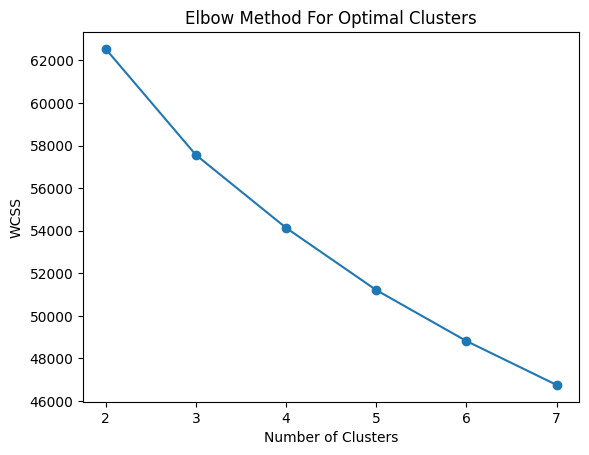

In [ ]:
# Select features for clustering
cluster_features = ['time_spent_on_videos', 'quiz_attempts', 'quiz_scores',
                    'forum_participation', 'assignment_completion_rate',
                    'final_exam_score', 'feedback_score']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cluster_features])

# Elbow method
wcss = []
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 8), wcss, marker='o')
plt.title("Elbow Method For Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['learner_cluster'] = kmeans.fit_predict(scaled_data)


## **Dropout Prediction Model**

Predicting dropout likelihood using Supervised Learning

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2011
           1       0.00      0.00      0.00       489

    accuracy                           0.80      2500
   macro avg       0.40      0.50      0.45      2500
weighted avg       0.65      0.80      0.72      2500



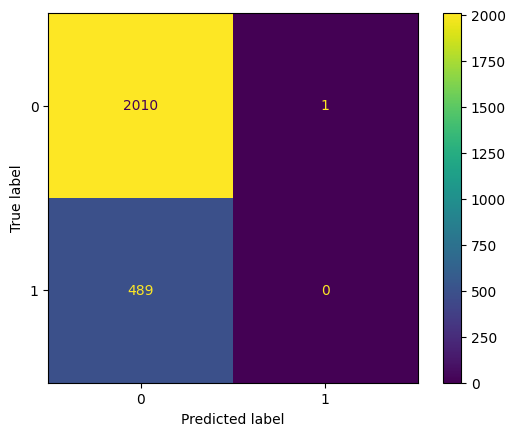

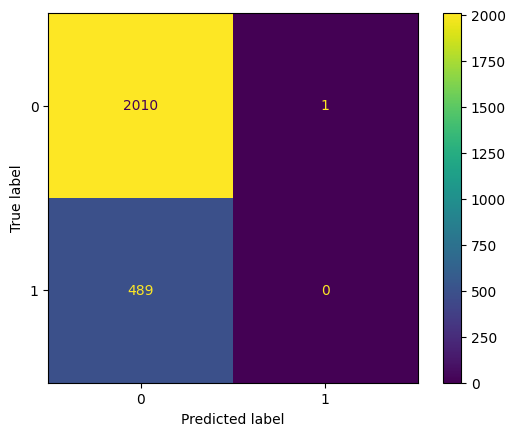

In [ ]:
# Define features
feature_cols = ['age', 'gender', 'time_spent_on_videos', 'quiz_attempts',
                'forum_participation', 'assignment_completion_rate', 'final_exam_score',
                'feedback_score', 'education_level_Undergraduate', 'education_level_Postgraduate',
                'learning_style_Visual', 'learning_style_Reading/Writing', 'learning_style_Kinesthetic']

X = df[feature_cols]
y = df['dropout_likelihood']

# Split & train
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test).plot()


## **Recommendation Engine**

In [ ]:
def recommend_course(user_input, kmeans_model, rf_model, scaler, cluster_features, feature_cols):
    user_df = pd.DataFrame([user_input])

    # Predict cluster
    cluster_data = scaler.transform(user_df[cluster_features])
    user_cluster = kmeans_model.predict(cluster_data)[0]

    # Predict dropout
    dropout_risk = rf_model.predict(user_df[feature_cols])[0]
    style = user_input.get('learning_style', 'Visual')

    # Recommendation logic
    if dropout_risk == 1:
        if style == 'Visual':
            return "⚠️ High dropout risk. Try: 'Python Basics' with visuals."
        elif style == 'Reading/Writing':
            return "⚠️ Try: 'Cybersecurity' with text-based material."
        else:
            return "⚠️ Try: 'Web Development' with interactive labs."

    elif user_cluster == 0:
        return "✅ High performer! Try: 'Data Science' or 'ML'."
    elif user_cluster == 1:
        return "📊 Moderate engagement. Try: 'Python Basics'."
    elif style == 'Kinesthetic':
        return "👨‍🔧 Try: Hands-on courses like 'Web Development'."
    else:
        return "📚 Suggest: Visual & forum-driven courses like 'ML' or 'Data Science'."


## **Test the Engine with sample users**

In [ ]:
user_input = {
    'age': 22,
    'gender': 0,
    'time_spent_on_videos': 300,
    'quiz_attempts': 3,
    'quiz_scores': 75,
    'forum_participation': 5,
    'assignment_completion_rate': 80,
    'final_exam_score': 70,
    'feedback_score': 4,
    'education_level_Undergraduate': 1,
    'education_level_Postgraduate': 0,
    'learning_style_Visual': 1,
    'learning_style_Reading/Writing': 0,
    'learning_style_Kinesthetic': 0,
    'learning_style': 'Visual'
}

recommend_course(user_input, kmeans, rf_model, scaler, cluster_features, feature_cols)


"📊 Moderate engagement. Try: 'Python Basics'."

## **Save Model**

In [ ]:
import joblib
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

## **Save Dataset**

In [ ]:
df.to_csv('/content/drive/MyDrive/results/clustered_personalized_learning_dataset.csv', index=False)

## **Conclusion**

We successfully clustered learners and predicted dropout likelihood. Based on these insights, we built a rule-based hybrid recommender system. Next we will deploy this model using a streamlit interface. We will visualize the behavioral insights using a Power BI dashboard.